# Assignment 1 - SIR model (ODE)
## Student: Boyan Mihaylov

This notebook contains the code used in conducting the experiments and obtaining the results described in the report for Assignment 1 of the course "Introduction to Computational Science".

### 1. Prerequisites

The following code imports the relavant libraries for the calculations:

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import math

The classic Runge-Kutta method [1](#references) will be implemented as default temporal discretization scheme:

In [3]:
def runge_kutta(fun, x, step):
        
        k1 = fun(x)*step
        k2 = fun(x+0.5*k1)*step
        k3 = fun(x+0.5*k2)*step
        k4 = fun(x+k3)*step
        return x + (k1+2*k2+2*k3+k4)/6

### 2. The SIR Class

Next the SIR model is defined as a Python class called `InfectionModel`, which will contain all the relevant input data for a specific disease, so that the outcomes of different diseases can be easily compared.

### 2.1. Initialization Function
At the initialization of the class, the values of $\beta$ (infection rate) and $\gamma$ (recovery rate) which will be used in the further calculations will be derived from "real-life" values as described in [2](#references) (p.17-18).

The definitions are as follows:

$\beta = -\kappa ln(1-C)$, where $\kappa$ is the number of individual contacts per unit time and $C$ is the probability of infection in the case of an infected contact.

$\gamma = 1/P_{inf}$ where $P_{inf}$ is the period of infection.

The parameters $k$, $C$ and $P_{inf}$ will be written down in the code as `k`, `c` and `pinf` respectively.

The basic reproductive ratio $R_0$ is defined such that $R_0=\frac{\beta}{\gamma}$.

Additionally, the population data will be initialized in the same function. The number of susceptible individuals $X$, infected ones $Y$ and recovered ones $Z$ will be available as optional arguments, which can either be user-defined or follow default values. The sum of the three quantities forms the population size $N$ and all of these values are then used to calculate the proportions of susceptibles $S$, infected $I$ and recovered $R$.

### 2.2. Differential equations
The system of differential equations governing the dynamics of the model will be defined in a special function called `SIR_nd` standing for "SIR model, no demography", which iterates over the clas-specific $S$, $I$ and $R$ variables, updates and returns their corresponding derivatives.

This module is created with the purpose to be exchanged in case a different dynamic system is to be used. The current equations are:

$$
\frac{dS}{dt}=-\beta S I\\
\frac{dI}{dt}= \beta S I - \gamma I\\
\frac{dR}{dt}= \gamma I
$$

The function for the differential equations is stored as a class variable upon initialization.

In [26]:
class InfectionModel:
    
    def __init__(self, k, c, pinf, X=999, Y=1, Z=0):
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        self.beta = -k*math.log(1-c)
        self.gamma = 1/pinf
        self.R0 = self.beta/self.gamma
        
        self.N = X+Y+Z
        self.S = X/self.N
        self.I = Y/self.N
        self.R = Z/self.N
        
        #print("S:" + str(self.S))
        
        self.ode = self.SIR_nd
        
    def SIR_nd(self, sir):
        
        self.dS = -self.beta*sir[0]*sir[1]
        self.dI = self.beta*sir[0]*sir[1] - self.gamma*sir[1]
        self.dR = self.gamma*sir[1]
        
        return np.array([self.dS, self.dI, self.dR])
        
    def iterate(self,step):
        
        self.S, self.I, self.R = runge_kutta(self.ode, np.array([self.S,self.I,self.R]),step)
        
    

### 3. Execution without demography

Next an instance of the InfectionModel class is created. The chosen parameters for this experiments are:
$$
\kappa = 8\\
C = 0.1\\
P_{inf} = 7
$$

We plot the development of the disease represented by the model over 90 days.

gamma: 0.14285714285714285
beta: 0.8428841252626103
R0: 5.900188876838272


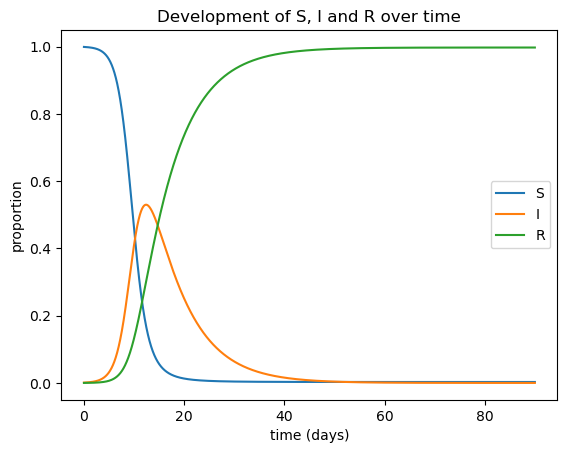

In [45]:
SIR = InfectionModel(8, 0.1, 7)

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))

# iteration step
step = 10e-3

# time in days
max_time = 90
time_elapsed = 0

S_log = []
I_log = []
R_log = []
time_log = []
while time_elapsed < max_time:
    S_log.append(SIR.S)
    I_log.append(SIR.I)
    R_log.append(SIR.R)
    time_log.append(time_elapsed)
    SIR.iterate(step)
    time_elapsed += step

plt.plot(time_log, S_log,label='S')
plt.plot(time_log, I_log,label='I')
plt.plot(time_log, R_log,label='R')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('proportion')
plt.title('Development of S, I and R over time')
plt.show()

The phase space diagrams of potential starting values of $S$ and $R$ is plotted by the following code:

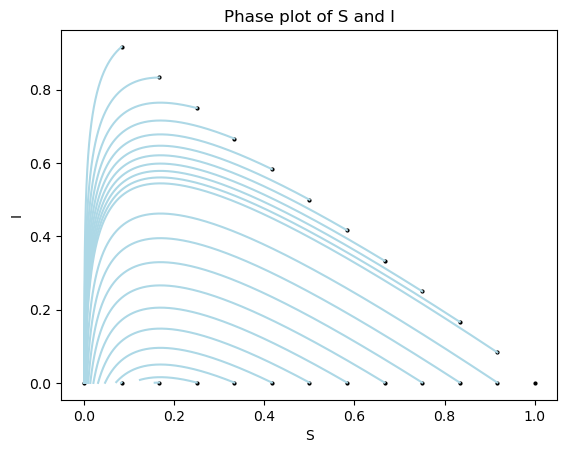

In [51]:
num_plots = 24
base_population = 1000
increment = base_population/num_plots

for x in range(num_plots):
    
    # time in days
    max_time = 90
    time_elapsed = 0
    
    if x < num_plots*0.5:
        X_start = x*increment*2
        Y_start = 1
        Z_start = base_population-x*increment*2-1
    else:
        X_start = base_population-(x-num_plots*0.5)*increment*2
        Y_start = (x-num_plots*0.5)*increment*2
        Z_start = 0
    
    SIR = InfectionModel(8, 0.1, 7, X_start, Y_start, Z_start)
    
    plt.plot(SIR.S,SIR.I,**{'marker':'o', 'markerfacecolor':'k', 'markeredgecolor':'k', 'markersize':2})
    
    S_log = []
    I_log = []
    R_log = []
    time_log = []
    while time_elapsed < max_time:
        S_log.append(SIR.S)
        I_log.append(SIR.I)
        R_log.append(SIR.R)
        time_log.append(time_elapsed)
        SIR.iterate(step)
        time_elapsed += step

    plt.plot(S_log, I_log,color='lightblue')
    plt.xlabel('S')
    plt.ylabel('I')
    plt.title('Phase plot of S and I')
plt.show()

### 4. Fitting of SIR model

The data from the influenza outbreak case is saved in an array called `cases`.

In [ ]:
cases = np.array([1,3,8,28,75,221,291,255,235,190,125,70,28,12,5])



<a id='references'></a>
[1] Kutta, Wilhelm - Beitrag zur näherungsweisen Integration totaler Differentialgleichungen (1901, Zeitschrift für Mathematik und Physik)

[2] Matt J. Keeling, Pejman Rohani - Modeling Infectious Diseases in Humans and Animals (2007, Princeton University Press)